In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


from helpers.physics_functions import bkg_fit_cubic, bkg_fit_septic, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calculate_test_statistic, get_errors_bkg_fit_ratio
from helpers.evaluation import get_median_percentiles
from helpers.plotting import newplot, hist_with_outline, hist_with_errors, function_with_band
from helpers.data_transforms import scaled_to_physical_transform
# Try to load LaTeX
latex_flag = False
np.seterr(divide='ignore')
plt.style.use("../science.mplstyle")

This notebook should be run twice:

1. `train_samesign = False` gives the "standard" results. i.e. we run the studies on the OS samples
2. `train_samesign = True` comes from running the Ml study on the SS samples.

**CAUTION**: for the histograms, we are truly showing the significance as $\frac{S}{\sqrt{B+{\sigma_B}^2}}$, i.e. we are accounting for the background error. For the ROC curves, this error is *NOT* being taken into account (it's not clear to me that we want this background error when we are just citing the background yield for the FPR)

In [ ]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 
    
feature_id = "mix_2"
bootstrap_flow = 0 # don't change this from 0

train_samesign = False
# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "SS"
else:
    train_data_id = "OS"

# train on opp sign means alt test set is samesign
if train_data_id == "OS": 
    alt_test_data_id = "SS"
elif train_data_id == "SS": 
    alt_test_data_id = "OS"

configs = "CATHODE_8"


# pickles contain all the results from the BDT training
working_dir = workflow["file_paths"]["working_dir"]
processed_data_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/"+workflow["analysis_keywords"]["name"]+"/processed_data"
flow_training_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/models/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/{configs}/"
pickle_save_dir = workflow["file_paths"]["data_storage_dir"] +"/projects/" + workflow["analysis_keywords"]["name"]+f"/pickles/bootstrap{bootstrap_flow}_{train_data_id}/{feature_id}/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 1001
n_folds = 5

In [ ]:
num_bins_SR = 12 # 16, 12, 8

pseudo_e_to_plot = 0 # this plots the actual data (not a boostrapped version)
fit_type = "quintic" # "cubic", "quintic", septic
if fit_type == "cubic": fit_function = bkg_fit_cubic
if fit_type == "quintic": fit_function = bkg_fit_quintic
if fit_type == "septic": fit_function = bkg_fit_septic

In [ ]:
SB_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_left"])
SR_left = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_left"])
SR_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SR_right"])
SB_right = float(workflow["window_definitions"][workflow["analysis_keywords"]["particle"]]["SB_right"])

print(SB_left, SB_right)



# Load in the data / BDT results

In [ ]:
with open(f"{flow_training_dir}/seed1/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(f"Feature Set: {feature_set}")



In [ ]:
# if train_samesign = False, this loads in the OS test data
# test 


def load_in_pseudoexperiments(file_string, num_pseudoexps):

    master_dict = {}

    with open(f"{pickle_save_dir}/{file_string}_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
        loc_dict = pickle.load(ifile)
    master_dict = {**loc_dict}
    # load in the bootstraps
    for i in range(1, num_pseudoexps):
        with open(f"{pickle_save_dir}/bkg_samples/bootstrap{i}/{file_string}_{fit_type}_{num_bins_SR}_0_1", "rb") as ifile:
            loc_dict = pickle.load(ifile)
            master_dict[i] = loc_dict[0]
    return master_dict

num_to_plot = 4

all_test_data_splits = load_in_pseudoexperiments("all_test_data_splits", num_to_plot)
print(len(all_test_data_splits.keys())==num_pseudoexperiments)

# test scores
all_scores_splits = load_in_pseudoexperiments("all_scores_splits", num_to_plot)
print(len(all_scores_splits.keys())==num_pseudoexperiments)

# alt data
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
all_alt_data_splits = load_in_pseudoexperiments("all_alt_data_splits", num_to_plot)
print(len(all_alt_data_splits.keys())==num_pseudoexperiments)
# alt scores
all_alt_scores_splits = load_in_pseudoexperiments("all_alt_scores_splits", num_to_plot)

print(len(all_alt_scores_splits.keys())==num_pseudoexperiments)

with open(f"{processed_data_dir}/mass_scaler_bootstrap{bootstrap_flow}", "rb") as ifile:
    old_scaler = pickle.load(ifile)
    
with open(f"{processed_data_dir}/preprocessing_info_bootstrap{bootstrap_flow}", "rb") as ifile:
     preprocessing_info = pickle.load(ifile)


## Plot histograms for a small number of FPR thresholds

In [ ]:
fpr_thresholds = [1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01]


"""
# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_to_plot)}

for pseudo_e in range(num_to_plot):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff
"""

In [ ]:

def plot_histograms_with_fits_SR(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, fit_type, num_bins_SR, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True):
    
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)
 
    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_masses = []

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            #loc_true_masses = mass_scalar(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
            
            
            loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs_by_fold[i_fold][threshold],plot_bins_left, plot_bins_right, plot_bins_SR)
            
            filtered_masses.append(loc_filtered_masses)
        # consolidate the fold information
        filtered_masses = np.concatenate(filtered_masses)
    
        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
        function_with_band(ax, fit_function, [SB_left, SB_right], popt, pcov, color = f"C{t}")

# def function_with_band(ax, f, range, params, pcov = None, color = "purple", alpha_line = 0.75, alpha_band = 0.25, lw = 3,  **kwargs):


        # calculate significance of bump
        S, B, q0 = calculate_test_statistic(filtered_masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov)
       
        significance = np.sqrt(q0)

        label_string = str(round(100*threshold, 2))+" S: " +str(round(S,0)) + ", B: " +str(round(B, 0)) + " Z: "+str(round(significance,2))

        # hist_with_errors(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        # hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")



    legend_title = f"Upsilon Resonances: Iso, Opp. Sign {feature_id}"
    plt.legend(loc = (0.975, 0.6), fontsize = 16, title = title[:-1])


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    #plt.yscale("log")
    plt.ylim(0, 300)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)
    

    # # Vertical Black Lines at boundaries of SR
    # plt.axvline(SR_left, color = "black", linestyle = "--", lw = 2)
    # plt.axvline(SR_right, color = "black", linestyle = "--", lw = 2)


    plt.title(title, fontsize = 24)



In [ ]:
"""
def plot_features_corner(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, SR_left, SR_right, n_folds= 5, take_score_avg=True):

    n_features = len(feature_set) - 1
    nbins = 50

    bins = {
        "dimu_pt": np.linspace(25, 100, nbins),
        "mu0_ip3d": np.logspace(-4, np.log10(0.3), nbins),
        "mu1_ip3d": np.logspace(-4, np.log10(0.3), nbins),
    }
    labels = {
        "dimu_pt": "$\mu^-\mu^+$ $p_T$ [GeV]",
        "mu0_ip3d": "Hardest $\mu$ 3D IP",
        "mu1_ip3d": "Softer $\mu$ 3D IP",
    }

    
    
    fig, ax = plt.subplots(n_features, n_features, figsize = (4*n_features, 4*n_features))
    
    for t, threshold in enumerate(fpr_thresholds[::-1]):

        label_string = str(round(100*threshold, 2))+"% FPR"
        
        filtered_features = {i:[] for i in range(n_features)}

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
                
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            
            
            loc_in_SR_indices =  (loc_true_masses >= SR_left) & (loc_true_masses <= SR_right) 
            loc_score_indices = (loc_scores >= score_cutoffs_by_fold[i_fold][threshold])
            
            loc_pass_indices = loc_in_SR_indices.reshape(-1,) & loc_score_indices.reshape(-1,)
            
            for i_feat in range(n_features):
                # undo the scaling
                selected_features = scaled_to_physical_transform(data_dict_by_fold[i_fold][:,i_feat], preprocessing_info[feature_set[i_feat]])
                filtered_features[i_feat].append(selected_features[loc_pass_indices])
                
        for i_feat in range(n_features):
            filtered_features[i_feat] = np.concatenate(filtered_features[i_feat])
            
       # PLOTTING   
            
        for i_feat in range(n_features):
            for j_feat in range(i_feat, n_features):
                

                plot_x = j_feat
                plot_y = i_feat

                if plot_x == n_features-1:
                    ax[plot_x, plot_y].set_xlabel(labels[feature_set[i_feat]])
                else:
                    ax[plot_x, plot_y].set_xticks([])
                if plot_y == 0:
                    ax[plot_x, plot_y].set_ylabel(labels[feature_set[j_feat]])
                else:
                    ax[plot_x, plot_y].set_yticks([])

                if i_feat == j_feat:
                    ax[plot_x, plot_y].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], histtype = "step", label=label_string)
                    ax[plot_x, plot_y].set_yscale("log")
                    #ax[plot_x, plot_y].set_xlabel(labels[feature_set[i_feat]])
                    ax[plot_x, plot_y].set_ylim(1e-1, 2*1e2)

                elif i_feat < j_feat:

                    ax[plot_x, plot_y].hist2d(filtered_features[i_feat], filtered_features[j_feat], bins = [bins[feature_set[i_feat]], bins[feature_set[j_feat]]], norm="log")
                    #ax[plot_x, plot_y].set_xlabel(labels[feature_set[i_feat]])
                    
                else:
                    ax[plot_x, plot_y].axis("off")
                   

        

    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    plt.legend(loc = (0.975, 0.4), fontsize = 16, title = legend_title[:-1])

    #ax[0].set_ylabel("Events", fontsize = 18)

    # Add more x ticks (major and minor)
    #plt.xticks(fontsize = 18)
    #plt.yticks(fontsize = 18)
    #plt.minorticks_on()
    #plt.tick_params(axis='x', which='minor', bottom=True)
    #plt.tick_params(axis='y', which='minor', left=True)
    plt.subplots_adjust(wspace=0, hspace= 0)
"""

In [ ]:
def plot_features(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, SR_left, SR_right, n_folds= 5, take_score_avg=True):

    n_features = len(feature_set) - 1
    nbins = 40

    bins = {
        "dimu_pt": np.linspace(0, 150, nbins),
        "mu0_ip3d": np.logspace(-4, 0, nbins),
        "mu1_ip3d": np.logspace(-4, 0, nbins),
    }
    labels = {
        "dimu_pt": "Dimuon $p_T$ [GeV]",
        "mu0_ip3d": "Muon 1 IP3D [cm]",
        "mu1_ip3d": "Muon 2 IP3D [cm]",
    }

    
    
    fig, ax = plt.subplots(1, n_features, figsize = (5*n_features, 5))
    
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_features = {i:[] for i in range(n_features)}

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
                
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
                 
            loc_in_SR_indices =  (loc_true_masses >= SR_left) & (loc_true_masses <= SR_right) 
            loc_score_indices = (loc_scores >= score_cutoffs_by_fold[i_fold][threshold])
            
            loc_pass_indices = loc_in_SR_indices.reshape(-1,) & loc_score_indices.reshape(-1,)
            
            for i_feat in range(n_features):
                # undo the scaling
                selected_features = scaled_to_physical_transform(data_dict_by_fold[i_fold][:,i_feat], preprocessing_info[feature_set[i_feat]])
                filtered_features[i_feat].append(selected_features[loc_pass_indices])
                
        for i_feat in range(n_features):
            filtered_features[i_feat] = np.concatenate(filtered_features[i_feat])   

        for i_feat in range(n_features):

            label_string = str(round(100*threshold, 2))+"% FPR"


            ax[i_feat].hist( filtered_features[i_feat], bins=bins[feature_set[i_feat]], lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
            ax[i_feat].set_yscale("log")
            if i_feat in [1, 2]:
                ax[i_feat].set_xscale("log")
                ax[i_feat].set_xticks([1e-3, 1e-2, 1e-1])
            ax[i_feat].set_xlabel(labels[feature_set[i_feat]])
            ax[i_feat].set_ylim(1e-1, 5*1e2)

            ax[i_feat].tick_params(labelsize = 16)

            if i_feat > 0:
                ax[i_feat].set_yticklabels([])


           

    legend_title = r"Upsilon Resonances: Iso, Opp. Sign"
    plt.legend(loc = (1.05, 0.4), fontsize = 16)

    ax[0].set_ylabel("Events", fontsize = 18)
    plt.subplots_adjust(wspace=0)

    return fig
    
    

In [ ]:
def plot_histograms_with_fits_SB(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, mass_scalar, fit_type, num_bins_SR, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True):
    
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)
 
    fig, ax = newplot("full", width = 12, height = 9, use_tex = latex_flag)

    all_data = np.vstack([data_dict_by_fold[i] for i in range(5)])
    all_scores = np.vstack([scores_dict_by_fold[i].reshape(-1,1) for i in range(5)])
    all_masses = mass_scalar.inverse_transform(all_data[:,-1].reshape(-1,1))
    in_SR = (all_masses >= SR_left ) & (all_masses <= SR_right)
    in_SBL = (all_masses < SR_left )
    in_SBH = (all_masses > SR_right )

    mass_SBL = all_masses[in_SBL]
    mass_SR = all_masses[in_SR]
    mass_SBH = all_masses[in_SBH]

    feature_SBL = all_scores[in_SBL]
    feature_SR = all_scores[in_SR]
    feature_SBH = all_scores[in_SBH]
    
    # Get a list of all possible cuts for the feature
    feature_cut_points = np.linspace(np.min(all_scores), np.max(all_scores), 10000)
       
    # For each cut, calculate the number of signal and background events in the SR
    num_in_SBL = []
    num_in_SR = []
    num_in_SBH = []
    FPR = []
    for cut in feature_cut_points:
        num_in_SBL.append(np.sum(feature_SBL >= cut)/len(feature_SBL))
        num_in_SR.append(np.sum(feature_SR >= cut)/len(feature_SR))
        num_in_SBH.append(np.sum(feature_SBH >= cut)/len(feature_SBH))

        FPR.append((np.sum(feature_SBH >= cut)+np.sum(feature_SBL >= cut))/(len(feature_SBH)+len(feature_SBL)))

    for t, threshold in enumerate(fpr_thresholds):

        # Use interpolation to find the cut point that gives the desired FPR
        best_feature_cut = feature_cut_points[np.argmin(np.abs(np.array(FPR)-threshold))]

        # Make the cuts to both the feature and the mass
        #feature_SBL_cut = feature_SBL[feature_SBL >= best_feature_cut]
        #feature_SR_cut = feature_SR[feature_SR >= best_feature_cut]
        #feature_SBH_cut = feature_SBH[feature_SBH >= best_feature_cut]

        mass_SBL_cut = mass_SBL[feature_SBL >= best_feature_cut]
        mass_SR_cut = mass_SR[feature_SR >= best_feature_cut]
        mass_SBH_cut = mass_SBH[feature_SBH >= best_feature_cut]

        # Concatenate to get the full mass spectrum
        filtered_masses = np.concatenate((mass_SBL_cut, mass_SR_cut, mass_SBH_cut))
        
        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    
        function_with_band(ax, fit_function, [SB_left, SB_right], popt, pcov, color = f"C{t}")

# def function_with_band(ax, f, range, params, pcov = None, color = "purple", alpha_line = 0.75, alpha_band = 0.25, lw = 3,  **kwargs):


        # calculate significance of bump
        S, B, q0 = calculate_test_statistic(filtered_masses, fit_function, fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt, pcov)
       
        significance = np.sqrt(q0)

        label_string = str(round(100*threshold, 2))+" S: " +str(round(S,0)) + ", B: " +str(round(B, 0)) + " Z: "+str(round(significance,2))

        # hist_with_errors(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        # hist_with_outline(ax, filtered_masses, bins = plot_bins_all, range = (SB_left, SB_right), lw = 3, color = f"C{t}",label = label_string)
        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string, alpha = 0.75)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")



    legend_title = f"Upsilon Resonances: Iso, Opp. Sign {feature_id}"
    plt.legend(loc = (0.975, 0.6), fontsize = 16, title = title[:-1])


    plt.axvline(SR_left, color= "k", lw = 3, zorder = 10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = 10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 18)
    plt.ylabel("Events", fontsize = 18)

    #plt.yscale("log")
    #plt.ylim(0, 300)

    # Add more x ticks (major and minor)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.minorticks_on()
    plt.tick_params(axis='x', which='minor', bottom=True)
    plt.tick_params(axis='y', which='minor', left=True)
    

    # # Vertical Black Lines at boundaries of SR
    # plt.axvline(SR_left, color = "black", linestyle = "--", lw = 2)
    # plt.axvline(SR_right, color = "black", linestyle = "--", lw = 2)


    plt.title(title, fontsize = 24)
    

    


# test:
- BDT discriminates `train_data_id` flow samples from `train_data_id` sample i and is evaluated on `train_data_id` sample i
- - (i.e. if `train_samesign = False`, then trained on OS flow samples and OS data, evaluated on OS data)
- i = 0: OS data, *with signal*
- i != 0: bkg-only flow samples from an independent flow

In [ ]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""

for i in range(num_to_plot):
    plot_histograms_with_fits_SB(fpr_thresholds, all_test_data_splits[i], all_scores_splits[i], 
                              old_scaler, fit_type, num_bins_SR,
                              f"OS samples, bootstrap {i}\n", 
                              SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


#fig = plot_features(fpr_thresholds, all_test_data_splits[0], all_scores_splits[0], score_cutoffs[0] , old_scaler, SR_left, SR_right, take_score_avg=False)

"""
plot_BDT(all_test_data_splits[0], all_scores_splits[0], score_cutoffs[0], 
              old_scaler, SR_left, SR_right, take_score_avg=False)
"""

# test SS
- BDT discriminates `train_data_id` flow samples from `train_data_id` sample i and is evaluated on ` not train_data_id` sample i
- - (i.e. if `train_samesign = False`, then trained on OS flow samples and OS data, evaluated on SS data)
- i = 0: SS data (no signal)
- i != 0: bkg-only flow samples from an independent flow

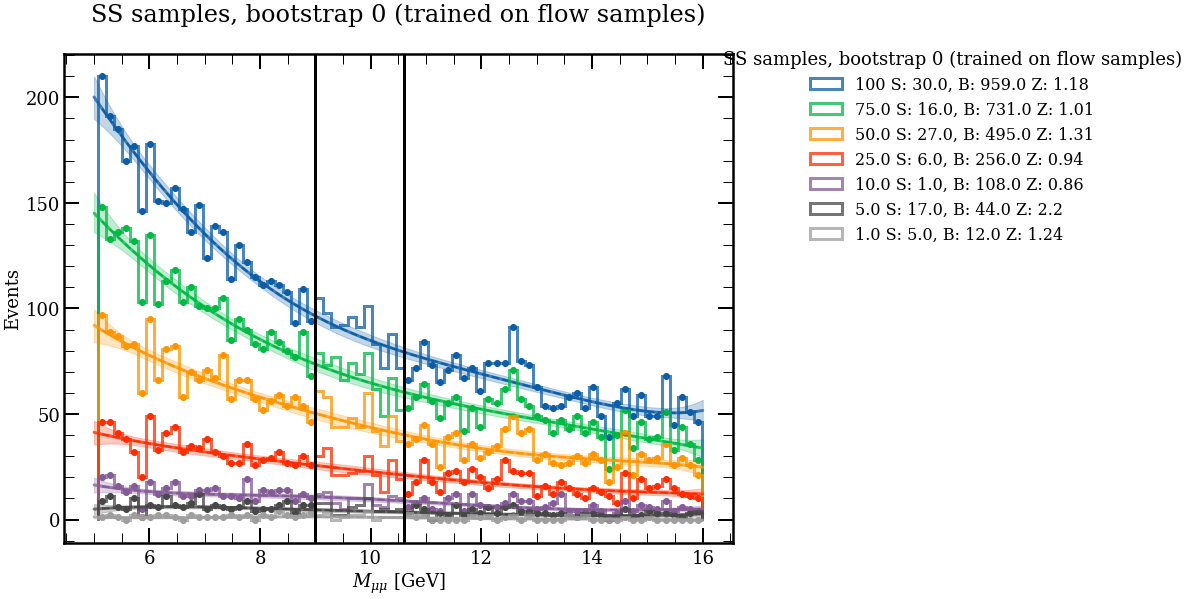

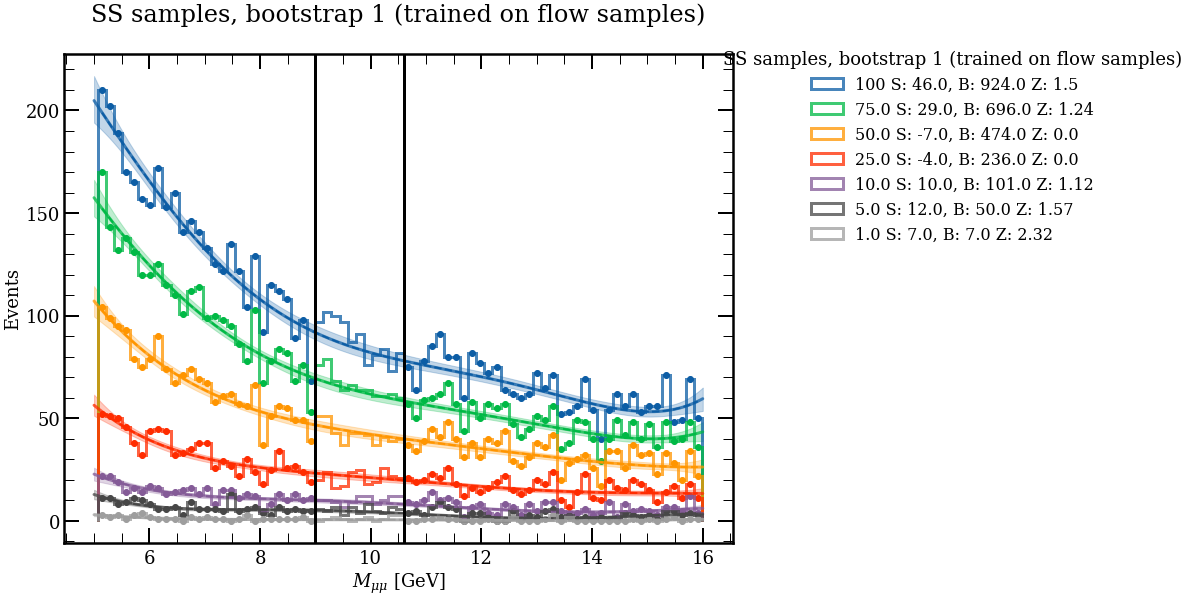

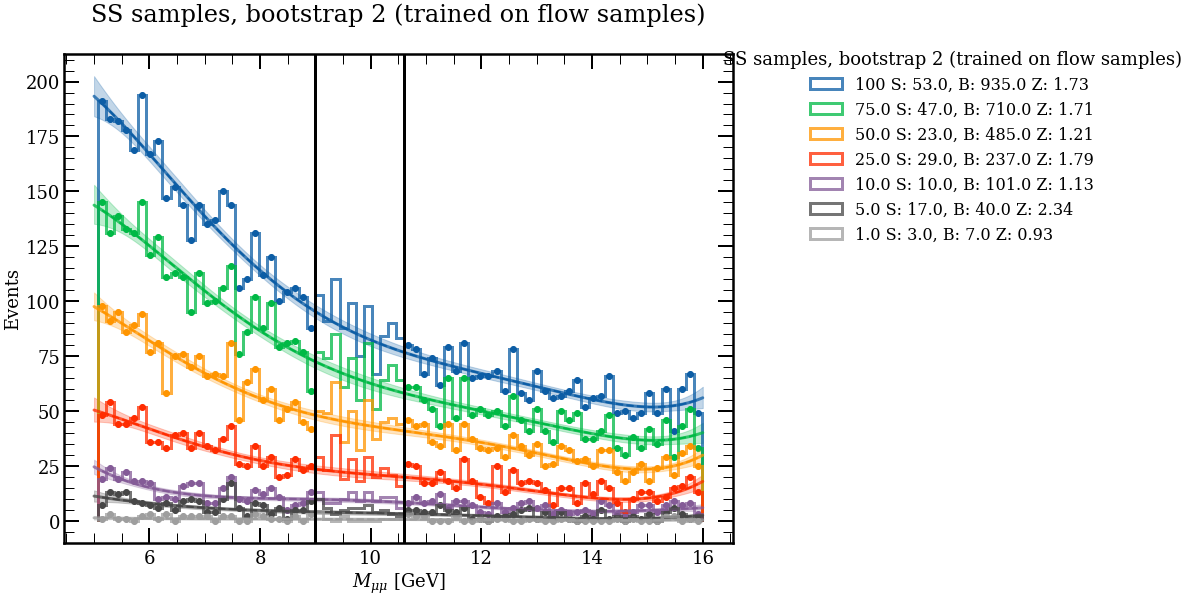

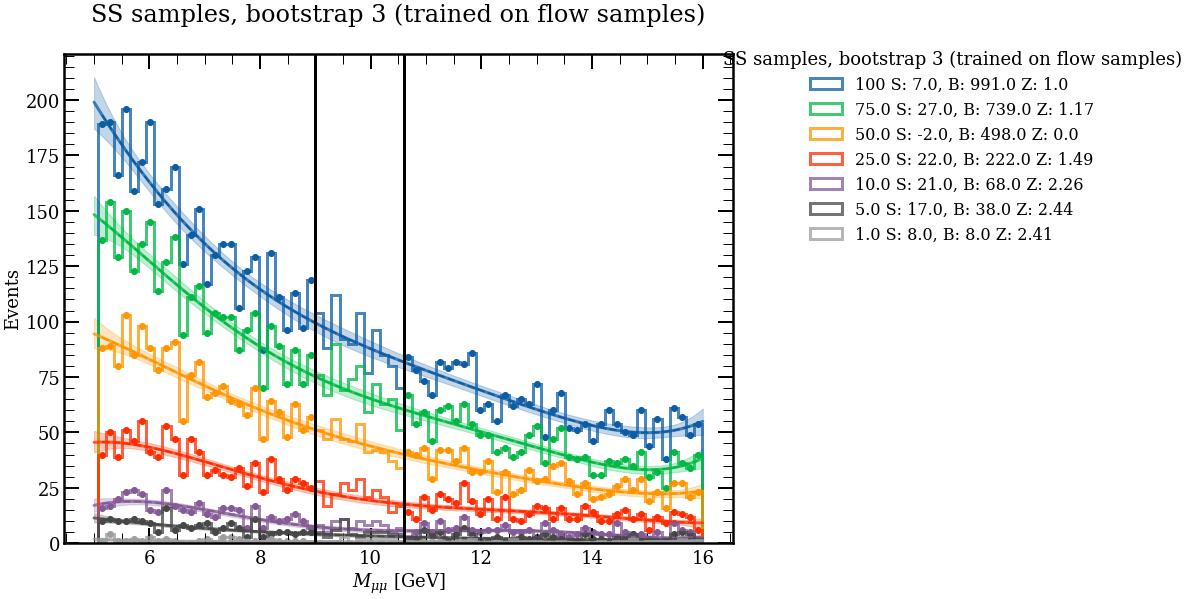

In [13]:


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
for i in range(num_to_plot):
    plot_histograms_with_fits_SB(fpr_thresholds, all_alt_data_splits[i]["alt"], 
                          all_alt_scores_splits[i]["alt"], old_scaler, 
                          fit_type, num_bins_SR,
                          f"SS samples, bootstrap {i} (trained on flow samples)\n",SB_left, 
                          SR_left, SR_right, SB_right, take_score_avg=False)


#plot_features(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], 
#              score_cutoffs[pseudo_e_to_plot], old_scaler, SR_left, SR_right, take_score_avg=False)



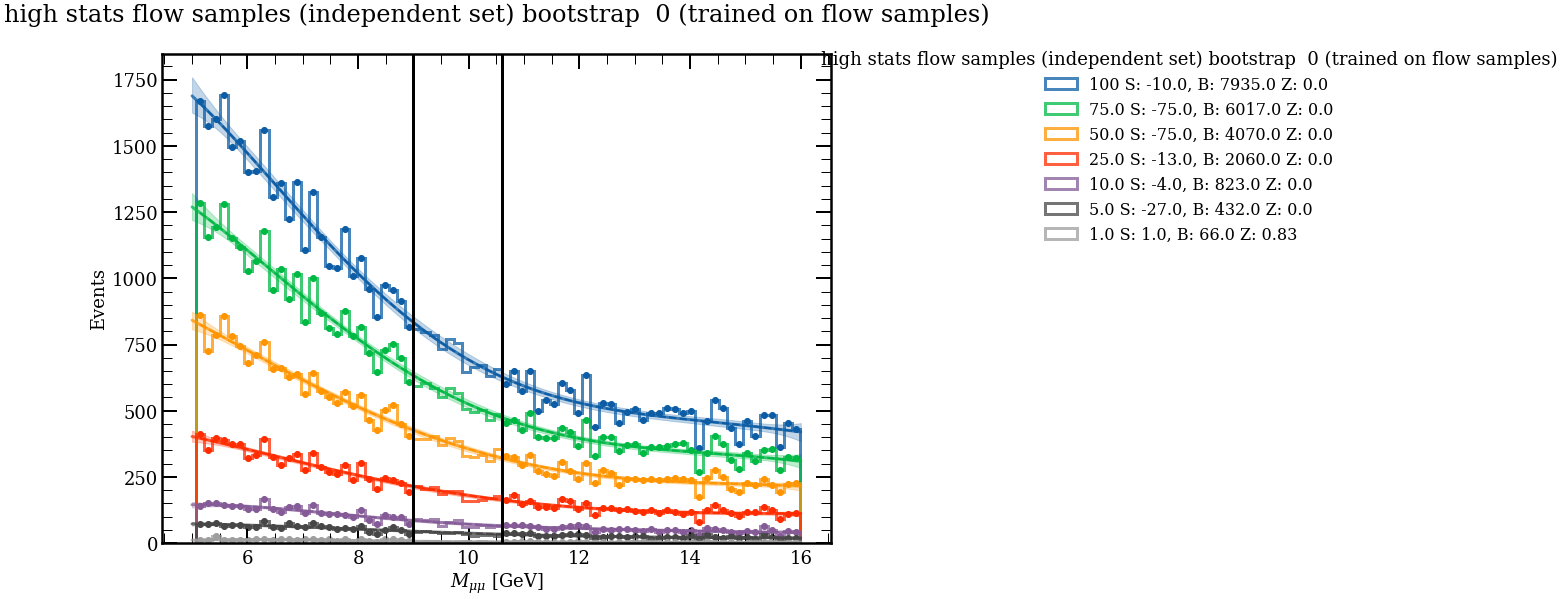

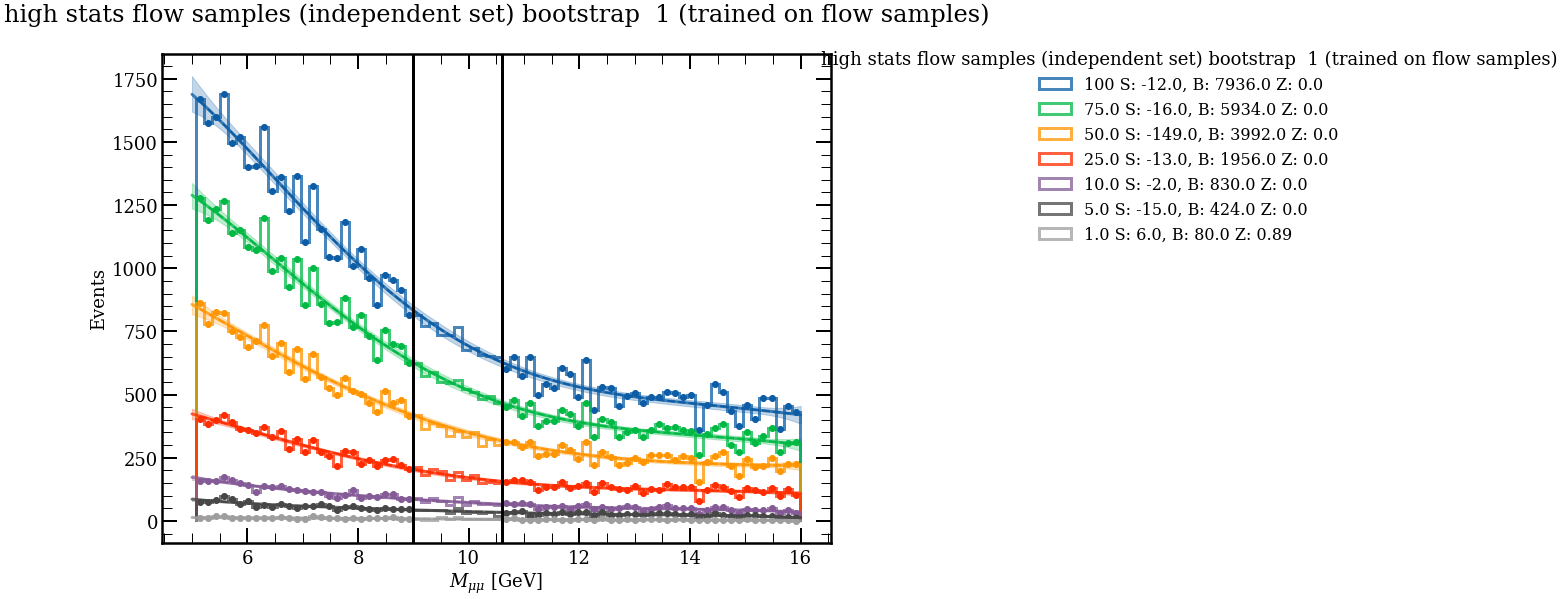

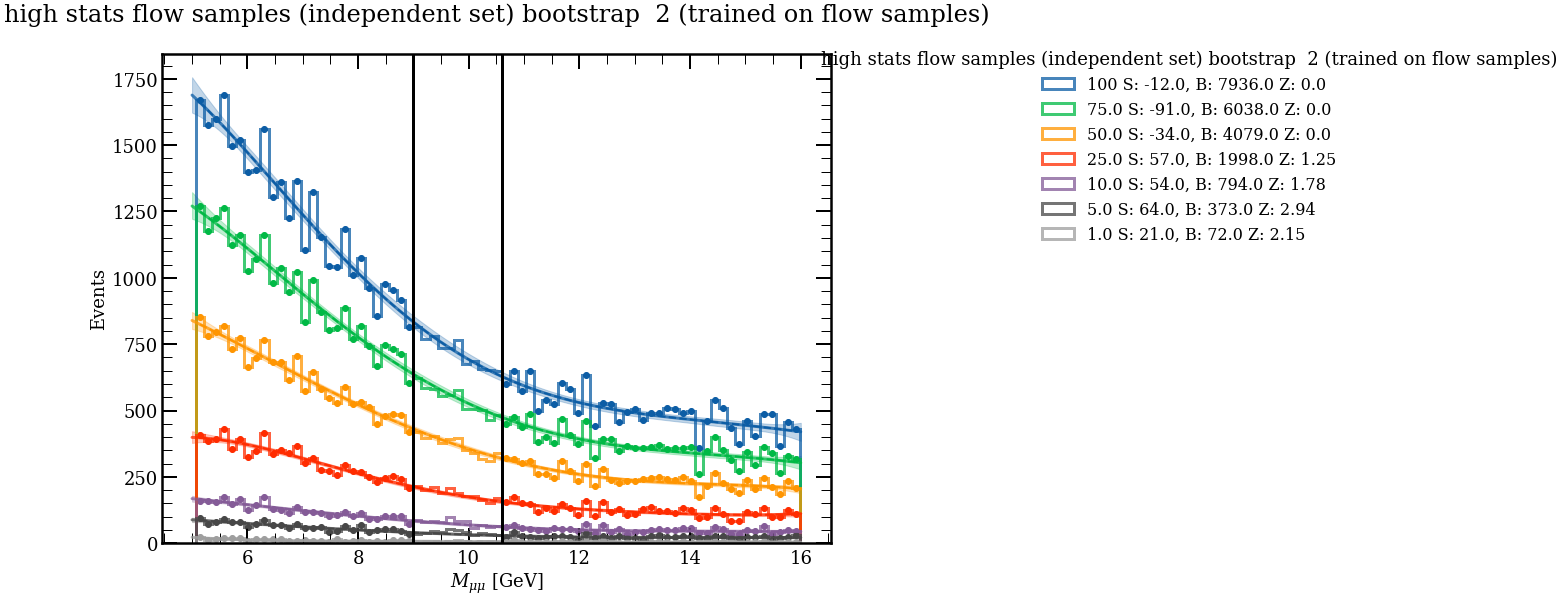

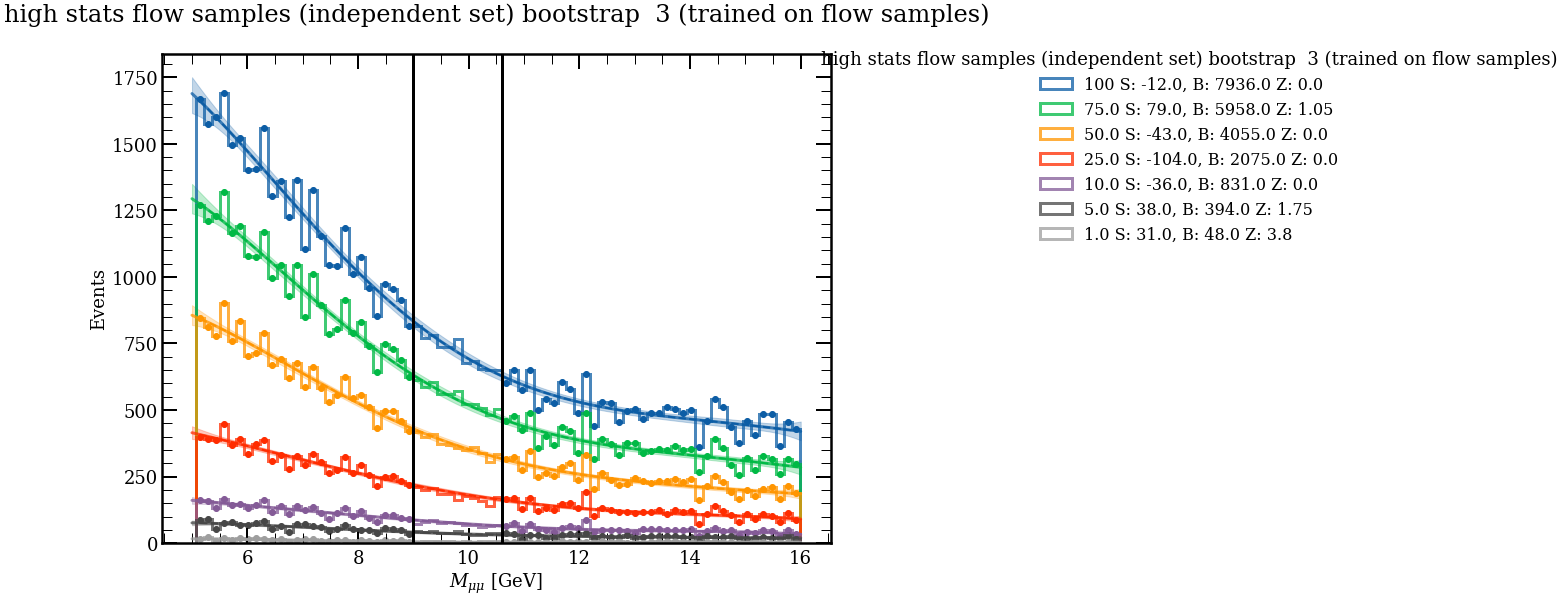

In [14]:
"""
PLOT HISTOGRAM ON FLOW SAMPLES
"""
for i in range(num_to_plot):
    plot_histograms_with_fits_SB(fpr_thresholds, all_alt_data_splits[i]["ROC_samples"], 
                          all_alt_scores_splits[i]["ROC_samples"], old_scaler, 
                          fit_type,num_bins_SR,
                          f"high stats flow samples (independent set) bootstrap  {i} (trained on flow samples)\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)
#plot_features(fpr_thresholds,  all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"],all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], 
#              score_cutoffs[pseudo_e_to_plot], old_scaler, SR_left, SR_right, take_score_avg=False)


# Plot ROC

Calculate the ROC curves for true S / B

In [ ]:


# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -3, 50)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = num_bins_SR)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff

        
def get_classifier_metrics_high_stats(dataset_by_pseudo_e, scores_by_pseudo_e, score_cutoffs):
            
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments))

    for pseudo_e in range(num_pseudoexperiments):

        print(f"On pseudo experiment {pseudo_e}...")
        for t, threshold in enumerate(fpr_thresholds_finegrained):

            filtered_masses_bs = []

            for i_fold in range(n_folds):
                loc_true_masses_bs = scaler.inverse_transform(np.array(dataset_by_pseudo_e[pseudo_e][i_fold][:,-1]).reshape(-1,1))
                loc_scores_bs = scores_by_pseudo_e[pseudo_e][i_fold]
                # filter top event based on score cutoff
                loc_filtered_masses_bs, _, _, _ = select_top_events_fold(loc_true_masses_bs, loc_scores_bs, score_cutoffs[pseudo_e][i_fold][threshold], plot_bins_left, plot_bins_right, plot_bins_SR)
                filtered_masses_bs.append(loc_filtered_masses_bs)

            filtered_masses_bs = np.concatenate(filtered_masses_bs)
            # get the fit function to SB background
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses_bs, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses_bs, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)

            y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
            B_error = np.sqrt(np.sum(y_err**2))
            S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
            
            
            significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

            # TODO: ERRORS
            
            S_yield[t, pseudo_e] = num_S_expected_in_SR
            B_yield[t, pseudo_e] = num_B_expected_in_SR
        
    # calculate summary stats
    TPR = S_yield/S_yield[0,:]
    FPR = B_yield/B_yield[0,:]
    
    

    ROC = 1.0/FPR

    SIC = TPR/np.sqrt(FPR)
    
    return TPR, FPR, ROC, SIC



In [ ]:
TPR, FPR, ROC, SIC = get_classifier_metrics_high_stats(all_test_data_splits, all_scores_splits, score_cutoffs_finegrained)

TPR_median, TPR_lower, TPR_upper = get_median_percentiles(TPR)
FPR_median, FPR_lower, FPR_upper = get_median_percentiles(FPR)
ROC_median, ROC_lower, ROC_upper = get_median_percentiles(ROC)
SIC_median, SIC_lower, SIC_upper = get_median_percentiles(SIC)

all_TPR[(fit_type, num_bins_SR)] = TPR_median, TPR_lower, TPR_upper
all_FPR[(fit_type, num_bins_SR)] = FPR_median, FPR_lower, FPR_upper
all_ROC[(fit_type, num_bins_SR)] = ROC_median, ROC_lower, ROC_upper
all_SIC[(fit_type, num_bins_SR)] = SIC_median, SIC_lower, SIC_upper

In [ ]:
colors_dict = {"cubic": "red", "quintic":"blue", "septic":"purple"}
styles_dict = {16:"solid", 12:"dashed", 8:"dotted"}

plt.figure()

for ff, nn in all_TPR.keys():
    plt.plot(all_FPR[(ff,nn)][0], all_TPR[(ff,nn)][0], label=f"{ff}, {nn}", color = colors_dict[ff], linestyle=styles_dict[nn])
    plt.fill_between(all_FPR[(ff,nn)][0], all_TPR[(ff,nn)][1], all_TPR[(ff,nn)][2], alpha = 0.2, color = colors_dict[ff] )
    
plt.plot(all_FPR[(ff,nn)][0], all_FPR[(ff,nn)][0], linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.legend(loc=(1,0))
plt.ylim(-1,6)
plt.ylabel("TPR")
plt.title(f"low-stats data _oppsign (trained on {train_data_id_title})")
plt.show()



In [ ]:

fig, ax = newplot("full", use_tex = latex_flag)
for ff, nn in all_TPR.keys():
    
    ax.plot(all_FPR[(ff,nn)][0], all_SIC[(ff,nn)][0], label=f"{ff}, {nn}", color = colors_dict[ff], linestyle=styles_dict[nn])
    ax.fill_between(all_FPR[(ff,nn)][0], all_SIC[(ff,nn)][1], all_SIC[(ff,nn)][2], alpha = 0.2, color = colors_dict[ff] )
ax.plot(all_FPR[(ff,nn)][0], all_FPR[(ff,nn)][0]/np.sqrt(all_FPR[(ff,nn)][0]), linestyle = "dashed", color = "grey")
plt.legend(loc=(1,0))
ax.set_xscale("log")
ax.set_xlabel("FPR")
ax.set_ylim(-1,30)
ax.set_ylabel("$S/\sqrt{B}$")


Calculate the ROC curves for data vs cathode samples

In [ ]:
from sklearn.metrics import roc_curve

fpr_interp = np.linspace(1e-5, 1, 100)
TPR = np.zeros((fpr_interp.shape[0], num_pseudoexperiments))

for pseudo_e in range(num_pseudoexperiments):

    print(f"On pseudo experiment {pseudo_e}...")
    
    scores_pseudo_e_data = []
    scores_pseudo_e_samples = []

    for i_fold in range(n_folds):
        scores_pseudo_e_data.append(all_scores_splits[pseudo_e][i_fold])
        scores_pseudo_e_samples.append(all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])

    scores_pseudo_e_data = np.concatenate(scores_pseudo_e_data)
    scores_pseudo_e_samples = np.concatenate(scores_pseudo_e_samples)

    scores_all = np.hstack([scores_pseudo_e_data,scores_pseudo_e_samples])
    labels_all = np.hstack([np.ones((scores_pseudo_e_data.shape[0],)),np.zeros((scores_pseudo_e_samples.shape[0],))])
    
    loc_fpr, loc_tpr, _ = roc_curve(labels_all, scores_all)
    tpr_interp = np.interp(fpr_interp, loc_fpr, loc_tpr)
    
    TPR[:,pseudo_e] = tpr_interp

    


In [ ]:
TPR_median, TPR_lower, TPR_upper = get_median_percentiles(TPR)

plt.plot(fpr_interp,TPR_median, lw = 0.5)
plt.fill_between(fpr_interp, TPR_lower, TPR_upper, alpha = 0.2)

plt.plot(fpr_interp,fpr_interp, linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()


    